# CNN

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
 
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

import shutil


filer_size = (3,3)
dropout_rate = 0.5
batch_size=32
num_of_epochs=5
learning_rate = 0.0001
optimizer = 'Adam'
image_size = 200

data = {
        "filer_size":filer_size, 
        "dropout_rate":dropout_rate, 
        "batch_size":batch_size,
        "num_of_epochs":num_of_epochs,
        "learning_rate":learning_rate,
        "optimizer":optimizer,
        "image_size":image_size
       }

#dir_name = os.mkdir('E:/Flower_Recognition/saved_results/scrach1')
#dir_name = 'E:/Flower_Recognition/saved_results/scrach1'
dir_name ='result'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
else:
    shutil.rmtree(dir_name)           # Removes all the subdirectories!
    os.makedirs(dir_name)


f = open(dir_name+"/info.txt", "w")
f.write("{\n")
for k in data.keys():
    f.write("'{}':'{}'\n".format(k, data[k]))
f.write("}")
f.close()

X=[]
Z=[]

#class folders
SIGN_cycten_DIR='../images/augmented_images/fractured'
SIGN_oxslate_DIR='../images/augmented_images/non-fractured'
# SIGN_RBC_DIR='/Users/kosrat/Downloads/dataset/GrayScal/RBC'
# SIGN_Uric_acide_DIR='/Users/kosrat/Downloads/dataset/GrayScal/Uric_acide'

In [2]:
def assign_label(img,sign_type):
    return sign_type

In [3]:
def make_train_data(sign_type,DIR):
    for img in os.listdir(DIR):
        label=assign_label(img,sign_type)
        path = os.path.join(DIR,img)
        # print('path ', path)
        # print('size ', image_size)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size,image_size))
        
        X.append(np.array(img))
        Z.append(str(label))

In [4]:
#train
make_train_data('fractured',SIGN_cycten_DIR)
# print(X)

make_train_data('non-fractured',SIGN_oxslate_DIR)
# print(X)

# make_train_data('RBC',SIGN_RBC_DIR)
# print(len(X))

# make_train_data('Uric_acide',SIGN_Uric_acide_DIR)
# print(len(X))



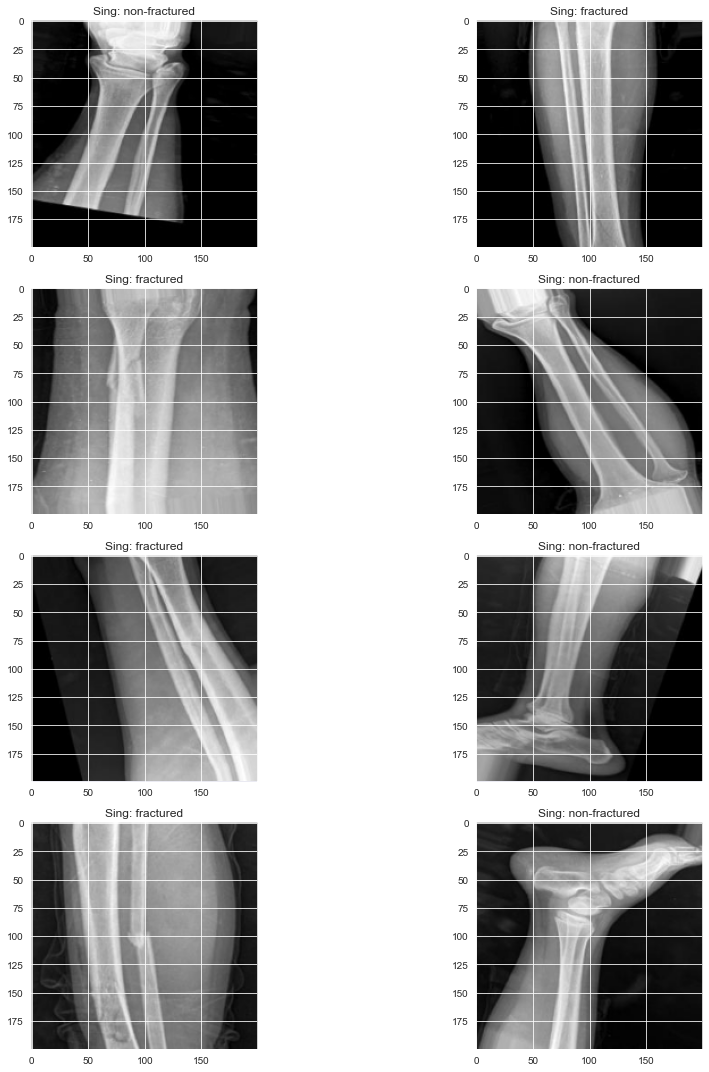

In [5]:
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Sing: '+Z[l])

plt.tight_layout()

In [6]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=keras.utils.to_categorical(Y,4)
X=np.array(X)
X=X/255

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.10,random_state=42)
# print(x_train)

In [8]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [9]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 22, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (image_size,image_size,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =40, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(dropout_rate))
model.add(Dense(256))
model.add(Dropout(dropout_rate))
model.add(Dense(128))
model.add(Dense(4, activation = "softmax"))

2022-06-08 21:57:30.450751: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [11]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [12]:
TRAIN_STEPS_PER_EPOCH = y_train.shape[0] // batch_size
VALID_STEPS_PER_EPOCH = y_test.shape[0] // batch_size

In [13]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [14]:
model.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
with open(dir_name+'/modelsummary.txt', 'w') as f:

    model.summary(print_fn=lambda x: f.write(x + '\n'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 22)      616       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 22)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      6368      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 40)        11560     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 40)       0

In [15]:
time_callback = TimeHistory()
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = num_of_epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[time_callback])

/var/folders/z2/rc11yvz52y5f0wwtxzjqbdm80000gn/T/ipykernel_36764/2541123294.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/5
87/87 [==============================] - 47s 528ms/step - loss: 0.7812 - accuracy: 0.5159 - val_loss: 0.6516 - val_accuracy: 0.6367
Epoch 2/5
87/87 [==============================] - 46s 523ms/step - loss: 0.6461 - accuracy: 0.6322 - val_loss: 0.6523 - val_accuracy: 0.6238
Epoch 3/5
87/87 [==============================] - 46s 521ms/step - loss: 0.5745 - accuracy: 0.6973 - val_loss: 0.5831 - val_accuracy: 0.7074
Epoch 4/5
87/87 [==============================] - 45s 519ms/step - loss: 0.5537 - accuracy: 0.7281 - val_loss: 0.4900 - val_accuracy: 0.7685
Epoch 5/5
87/87 [==============================] - 45s 517ms/step - loss: 0.5148 - accuracy: 0.7509 - val_loss: 0.4413 - val_accuracy: 0.7878


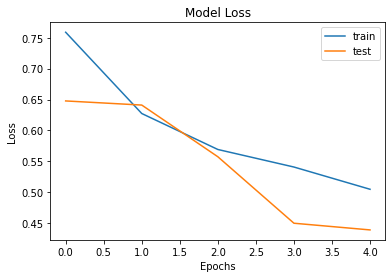

In [26]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.rcParams['figure.figsize'] = [15, 10]
plt.savefig(dir_name+'/loss.png')
#plt.show()

In [27]:
print(y_test)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


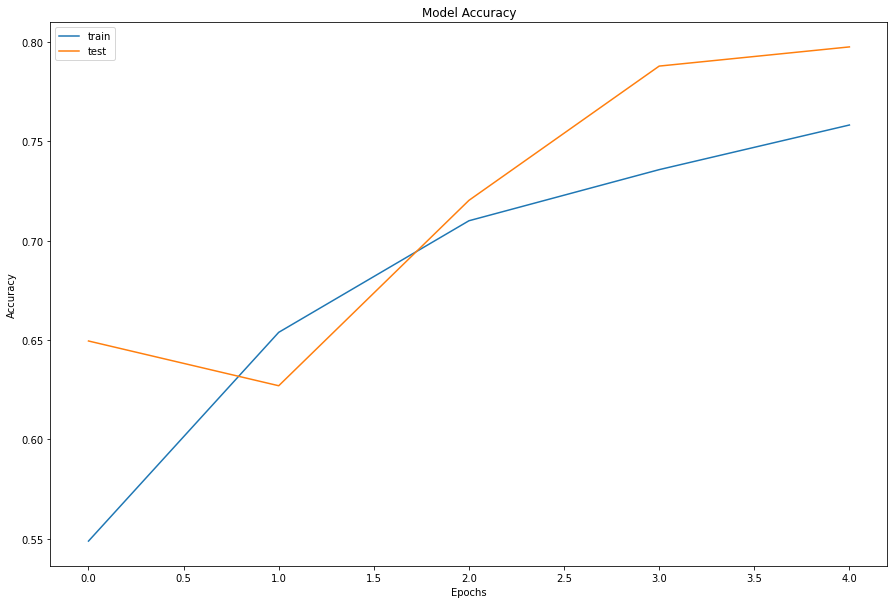

In [28]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.rcParams['figure.figsize'] = [15, 10]
plt.savefig(dir_name+'/acc.png')
plt.show()

In [29]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
print(pred_digits)

[1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0
 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1
 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0]


In [30]:
target_names = ['fractured', 'non-fractured']
y_test1=np.argmax(y_test, axis=1)
Y_pred = model.predict_generator(x_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test1, y_pred)
print(cm)
acc = accuracy_score(y_test1, y_pred)
print(acc)
f = open(dir_name+"/acc.txt", "w")
f.write(str(acc))

/var/folders/z2/rc11yvz52y5f0wwtxzjqbdm80000gn/T/ipykernel_13148/4235573527.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(x_test)


Confusion Matrix
[[160   7]
 [ 56  88]]
0.797427652733119


17

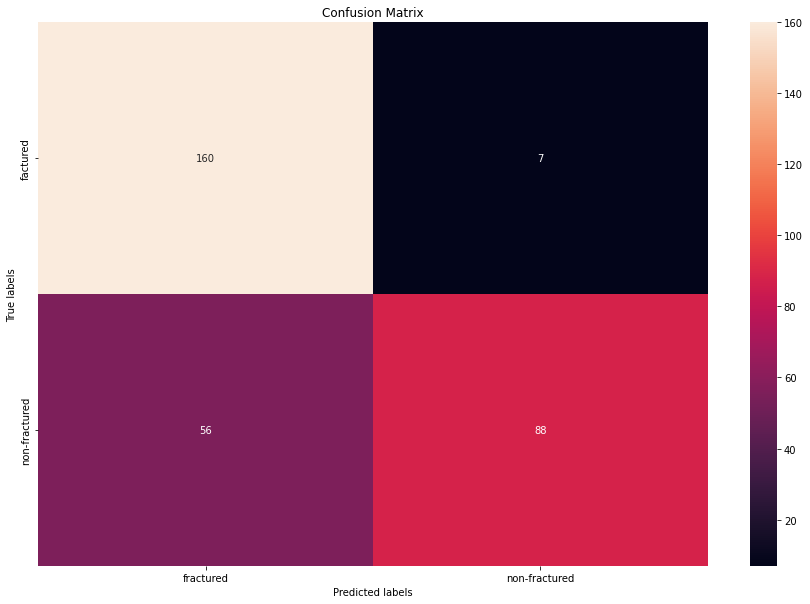

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fractured', 'non-fractured']); 
ax.yaxis.set_ticklabels(['factured', 'non-fractured']);

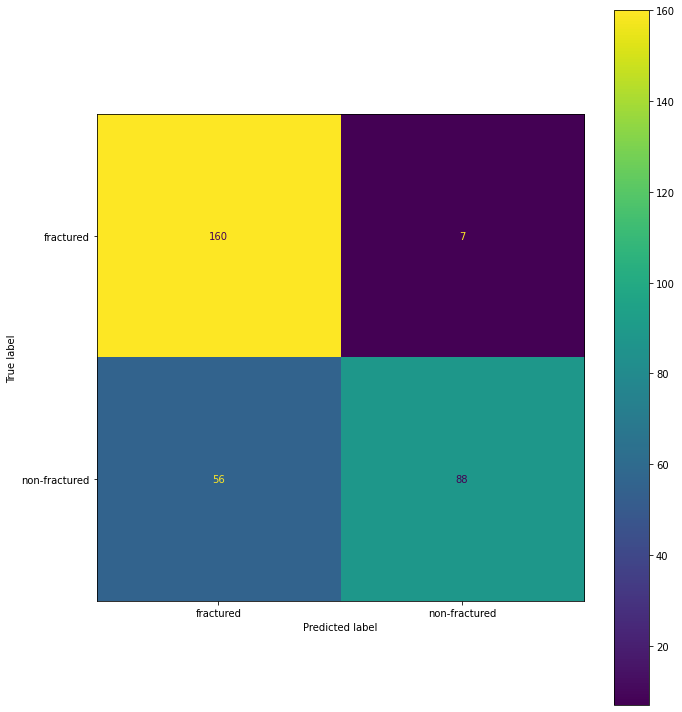

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(cm, display_labels=['fractured', 'non-fractured'])
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)
plt.tight_layout()
plt.savefig(dir_name+'/cm.png')

In [33]:
model.save(dir_name+'/model.h5')

In [34]:
from keras import models
import cv2 
import numpy as np 
model = models.load_model('/Users/kosrat/Downloads/kk/model.h5')
img = cv2.imread('/Users/kosrat/Downloads/dataset/training_set/fractured/1.jpg')
img = cv2.resize(img,(200,200))
img = np.reshape(img,[1,200,200,3])

#classes = model.predict_classes(img)
classes = (model.predict(img) > 0.5).astype("int32")

print(classes)

OSError: No file or directory found at /Users/kosrat/Downloads/kk/model.h5